In [1]:
import numpy as np
import mne
import matplotlib
%matplotlib inline
#%matplotlib qt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import scipy
import pickle
import networkx as nx
import igraph as ig
import preprocessing as prep
from epoch_connectivity import ConnEEG as cnegg
from epoch_connectivity import ConnectionMatrices as cm
from itertools import permutations

from epoch_connectivity.utils import FrequencyBand, only_EEG_channels

import mne_connectivity as mnecon

In [58]:
class Connectome(object):
    def __init__(self, ConnectionMatrix, channel_names, thresholding_method=None, threshold=None):
        adjacency_matrix = ConnectionMatrix.copy()
        ch_names = channel_names
        
        #To create the network
        sinks, sources  = np.shape(adjacency_matrix)
        np.fill_diagonal(adjacency_matrix, 0) # no self-loops
        
        if thresholding_method is not None:

            if thresholding_method == "density":
                adjacency_flatten = adjacency_matrix.flatten()
                to_pick = int(threshold * len(adjacency_flatten))
                adjacency_flatten.sort()
                thresh = adjacency_flatten[-to_pick]
            elif thresholding_method == "absolut":
                thresh = threshold
                
            adjacency_matrix[adjacency_matrix >= thresh] = 1
            adjacency_matrix[adjacency_matrix < thresh] = 0
            
        relabel = {}
        for i in range(sinks):
            relabel[i] = ch_names[i]
                    
        network = nx.DiGraph(adjacency_matrix.T)
        network = nx.relabel_nodes(network, relabel, copy=True)
        for edge in network.edges:
            network[edge[0]][edge[1]]['length'] = 1 / network[edge[0]][edge[1]]['weight']
        
        self.network = network
    
    """def modularity(self):
        communities = [{'F3', 'Fp1', 'Fp2', 'F4'}, {'Fz', 'C3', 'Cz', 'C4', 'Pz'}, {'F7', 'T3', 'T5'},
                      {'F8', 'T4', 'T6'}, {'P3', 'O1', 'O2', 'P4'}]
        modularity = nx.algorithms.community.modularity(G=self.network, communities=communities, weight='lenght')
        return modularity"""

    def modularity(self):
        network_igraph = ig.Graph.from_networkx(self.network)
        membership = [1, 1, 1, 0, 0, 2, 3, 0, 0, 1, 4, 4, 4, 4, 1, 2, 3, 2, 3]
        return network_igraph.modularity(membership, weights='length')
    
    def optimized_modularity(self):
        communities = nx.algorithms.community.greedy_modularity_communities(G=self.network, weight='length', n_communities=5)
        modularity = nx.algorithms.community.modularity(G=self.network, communities=communities, weight='lenght')
        return modularity
        
    def avg_betweenness_centrality(self):
        bc = np.array(list(nx.betweenness_centrality(G=self.network, normalized=True, weight='length', endpoints=False).values()))
        return bc.mean()
    
    def global_efficiency_weighted(self):
       n = len(self.network)
       denom = n * (n - 1)
       if denom != 0:
           shortest_paths = dict(nx.all_pairs_dijkstra(self.network, weight = 'length'))
           g_eff = sum(1./shortest_paths[u][0][v] if shortest_paths[u][0][v] !=0 else 0 for u, v in permutations(self.network, 2)) / denom
       else:
           g_eff = 0
       return g_eff
    
    def degree_assortativity(self):
        return nx.degree_pearson_correlation_coefficient(G=self.network, weight='length')
    
    def avg_clustering_coefficient(self):
        return nx.average_clustering(G=self.network, weight='length')
    
    def plot_freqband_measure(self, measure, freq_band, patient, status, n_strongest_connections = 30):
        pos = {'Fp1':(295, 120), 'Fp2':(435, 120), 'F7':(190, 200), 'F8':(540,200), 'F3':(280, 215), 'Fz':(370, 215),
       'F4':(455, 215), 'T3':(150, 325), 'C3':(260, 325), 'Cz':(370, 325), 'C4':(475, 325), 'T4':(585, 325),
       'T5':(190, 450), 'T6':(540, 450), 'P3':(280, 435), 'Pz':(370, 435), 'P4':(455, 435), 'O1':(295, 530),
       'O2':(435, 530)}

        def last(n):
            return n[-1]  

        img = plt.imread("epoch_connectivity/10-20.png")
        fig, ax = plt.subplots()
        ax.imshow(img, aspect='equal')
                
        nx.draw_networkx_nodes(self.network, pos, cmap=plt.get_cmap('jet'), node_size = 500, alpha=0.7)
        nx.draw_networkx_labels(self.network, pos)

        filtered_edges = sorted(self.network.edges(data='weight'), key=last)[-n_strongest_connections:]

        edges, weights = [], []
        for edgew in filtered_edges:
            edges.append((edgew[0], edgew[1]))
            weights.append(edgew[2])

        nx.draw_networkx_edges(self.network, pos, edgelist=edges, edge_color=weights, width=3, edge_cmap=plt.cm.viridis)
        plt.suptitle(measure + ' on ' + freq_band + ' band for patient ' + str(patient) + ' while ' + status, fontsize=12)
    

class Connectomes(object):
    def __init__(self, PatientConnectionMatrices, measure, thresholding_method=None, threshold=None):
        self.CMs = PatientConnectionMatrices
        self.measure = measure
        self.adjacency_matrices = getattr(self.CMs, measure)
        nodes_names = only_EEG_channels(self.CMs.epoched_eeg.ch_names)
        self.is_binary = False
        
        if thresholding_method is not None:
            self.is_binary = True
        
        networks = {}
        for i in range(len(self.CMs.f_bands)):
            f_band = self.CMs.f_bands[i]
            networks[f_band] = Connectome(self.adjacency_matrices[i], nodes_names, thresholding_method=thresholding_method,
                                          threshold=threshold)
        
        self.networks = networks
            
    
    def modularity(self):
        modularity = {}
        for f_band in self.CMs.f_bands:
            modularity[f_band] = self.networks[f_band].modularity()
        return modularity
    
    def optimized_modularity(self):
        optimized_modularity = {}
        for f_band in self.CMs.f_bands:
            optimized_modularity[f_band] = self.networks[f_band].optimized_modularity()
        return optimized_modularity
        
    def avg_betweenness_centrality(self):
        avg_betweenness_centrality = {}
        for f_band in self.CMs.f_bands:
            avg_betweenness_centrality[f_band] = self.networks[f_band].avg_betweenness_centrality()
        return avg_betweenness_centrality
    
    def global_efficiency_weighted(self):
        g_eff = {}
        for f_band in self.CMs.f_bands:
            g_eff[f_band] = self.networks[f_band].global_efficiency_weighted()
        return g_eff
    
    def degree_assortativity(self):
        degree_assortativity = {}
        for f_band in self.CMs.f_bands:
            degree_assortativity[f_band] = self.networks[f_band].degree_assortativity()
        return degree_assortativity
    
    def avg_clustering_coefficient(self):
        avg_clustering_coefficient = {}
        for f_band in self.CMs.f_bands:
            avg_clustering_coefficient[f_band] = self.networks[f_band].avg_clustering_coefficient()
        return avg_clustering_coefficient
    
        
    def plot_measure(self, n_strongest_connections=30, savefigure=False, fformat='.pdf', directory=None):
        
        pos = {'Fp1':(295, 120), 'Fp2':(435, 120), 'F7':(190, 200), 'F8':(540,200), 'F3':(280, 215), 'Fz':(370, 215),
       'F4':(455, 215), 'T3':(150, 325), 'C3':(260, 325), 'Cz':(370, 325), 'C4':(475, 325), 'T4':(585, 325),
       'T5':(190, 450), 'T6':(540, 450), 'P3':(280, 435), 'Pz':(370, 435), 'P4':(455, 435), 'O1':(295, 530),
       'O2':(435, 530)}
        img = plt.imread("epoch_connectivity/10-20.png")
        def last(n):
            return n[-1]  
        
        n_plot = len(self.CMs.f_bands)
        v, h = 3, int(np.ceil(n_plot/3))
        axes = []
        fig = plt.figure(figsize=[h*6.4, v*4.8])
        all_weights, all_edges = [], []
        for i in range(n_plot):
            axes.append(fig.add_subplot(v*100+h*10+i+1))        
            f = self.CMs.f_bands[i]
            net_measure_frequency = self.networks[f].network
            filtered_edges = sorted(net_measure_frequency.edges(data='weight'), key=last)[-n_strongest_connections:]
            edges, weights = [], []
            for edgew in filtered_edges:
                edges.append((edgew[0], edgew[1]))
                weights.append(edgew[2])
            all_weights.append(weights)
            all_edges.append(edges)
        all_weights, all_edges = np.array(all_weights), np.array(all_edges)
        max_weight, min_weight = np.amax(all_weights), np.amin(all_weights)

        plt.subplots_adjust(top=0.90)
        for i in range(n_plot):
            f = self.CMs.f_bands[i]
            net_measure_frequency = self.networks[f].network
            axes[i].imshow(img)
            
            nx.draw_networkx_nodes(net_measure_frequency, pos, cmap=plt.get_cmap('Accent'),
                                   node_size = 500, ax=axes[i], alpha=0.7)
            nx.draw_networkx_labels(net_measure_frequency, pos, ax=axes[i])

            weights = all_weights[i].copy()
            edges = all_edges[i].copy()
            
            cmap = plt.cm.viridis

            nx.draw_networkx_edges(net_measure_frequency, pos, edgelist=edges, edge_color=weights,
                    width=3, edge_cmap=cmap, ax=axes[i], edge_vmax=max_weight, edge_vmin=min_weight)
            
            if not self.is_binary:                        
                norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
                fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[i], orientation='vertical')
    
            axes[i].set_title(f)
        fig.suptitle(self.measure + ' on patient ' + str(self.CMs.patient) + ' while ' + self.CMs.rec_status, fontsize=16, y=0.94)
        if savefigure:
            save_file_name = 'connectome_PAT' + str(self.CMs.patient) + '_' + self.CMs.rec_status + '_' + self.measure + fformat
            plt.savefig(directory+save_file_name)

In [53]:
direc_pickle = 'C:/code_thesis/brain_connectivity_epilepsy/connection_matrices/'
pat_num = 1
patient_code = 'PAT'+str(pat_num)
MyCM = pickle.load(open(direc_pickle+patient_code+'_'+'AWAKE.pickle', 'rb'))

In [50]:
nodes_names = only_EEG_channels(MyCM.epoched_eeg.ch_names)
ctom = Connectome(MyCM.PDC[0], nodes_names, thresholding_method='density', threshold=0.3)

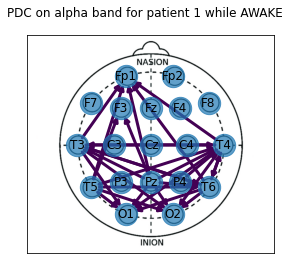

In [51]:
ctom.plot_freqband_measure(measure='PDC', freq_band='alpha', patient=1, status='AWAKE', n_strongest_connections = 30)

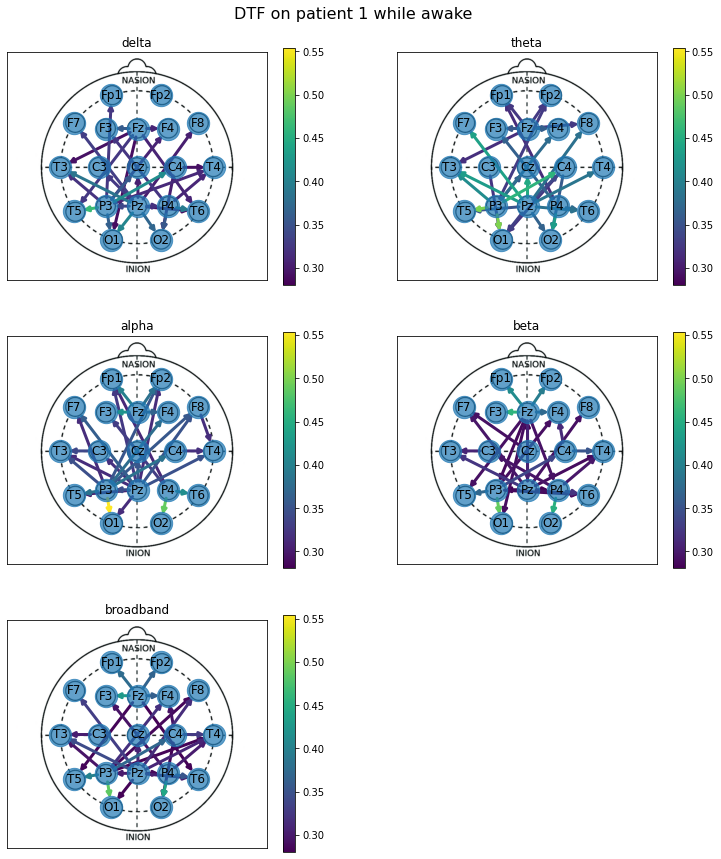

In [64]:
Cntome = Connectomes(MyCM, 'DTF')#,  thresholding_method='density', threshold=0.3)
directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
Cntome.plot_measure(savefigure=False, fformat='.pdf', directory=directoryr, n_strongest_connections=30)

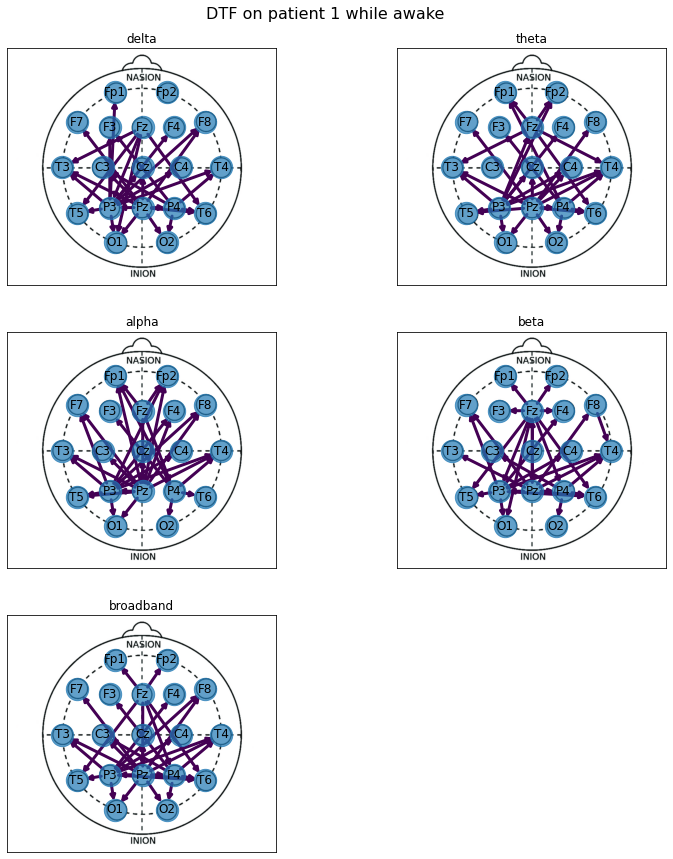

In [65]:
Cntome = Connectomes(MyCM, 'DTF',  thresholding_method='density', threshold=0.1)
directoryr = 'C:/code_thesis/brain_connectivity_epilepsy/plots/'
Cntome.plot_measure(savefigure=False, fformat='.pdf', directory=directoryr, n_strongest_connections=30)

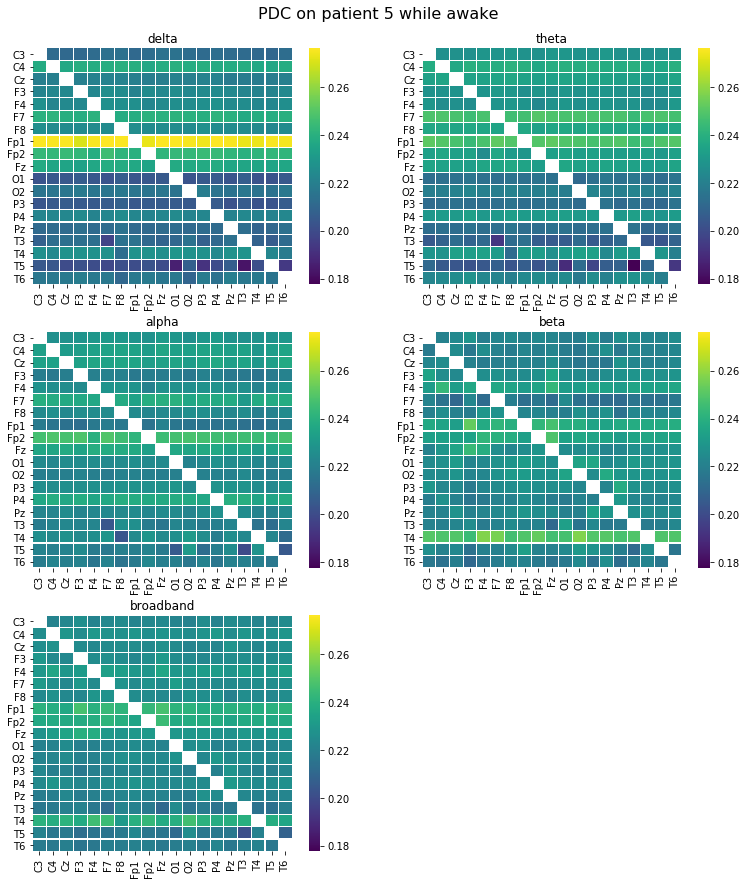

In [56]:
MyCM.plot_fbands_hmaps(measure='PDC', savefigure=False, hide_diag=True)